# Wine Analysis

This notebook analyzes wine review data and creates visualizations.


In [24]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


## Load and Clean Data


In [25]:
CSV_PATH = Path("winemag-data-130k-v2.csv")
wine_df = pd.read_csv(CSV_PATH, low_memory=False)
wine_df = wine_df.drop(columns=["Unnamed: 0"], errors="ignore")

wine_df["country"] = wine_df["country"].fillna("Unknown")
wine_df["province"] = wine_df["province"].fillna("Unknown")
wine_df["variety"] = wine_df["variety"].fillna("Unknown")

wine_df["points"] = pd.to_numeric(wine_df["points"], errors="coerce")
wine_df["price"] = pd.to_numeric(wine_df["price"], errors="coerce")

wine_df.head()


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## Plot 1: Review Counts by Country (Stacked by Rating Bands)
Shows the top countries by review count, with reviews stacked by rating bands (80-84, 85-89, 90-94, 95-100). 


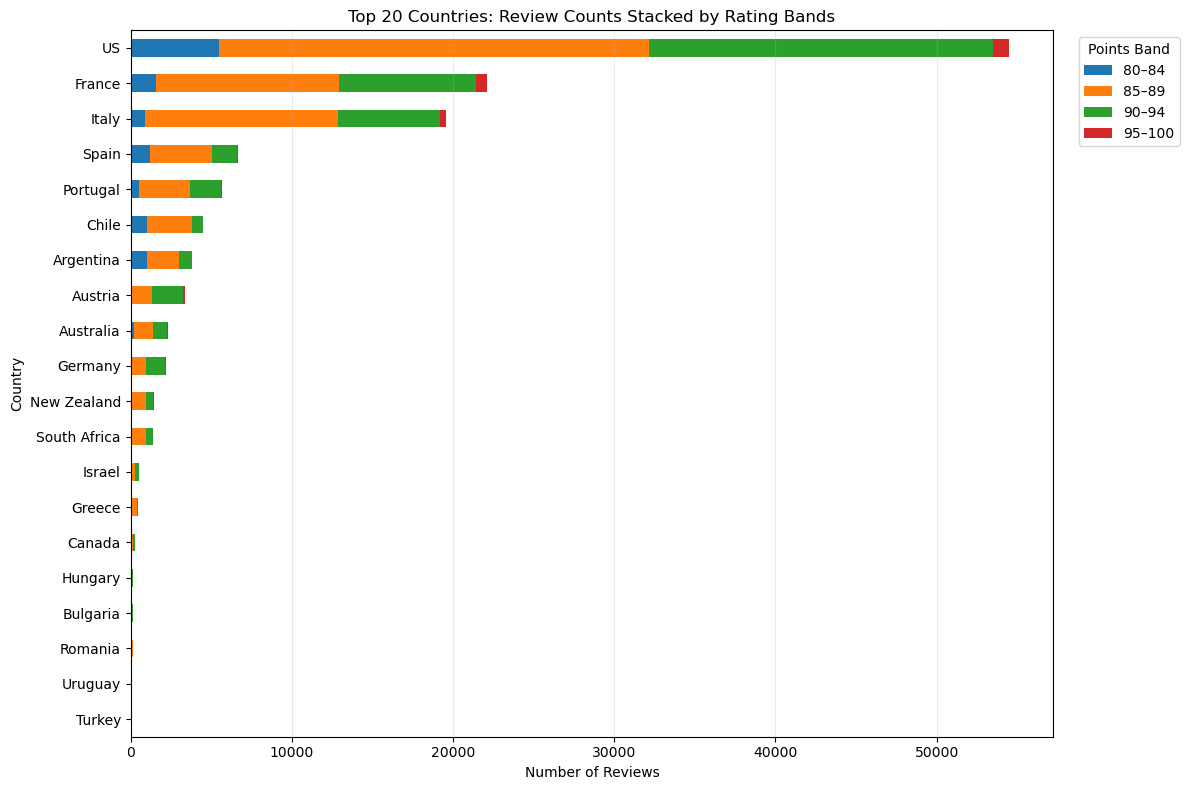

In [26]:
df_with_points = wine_df.dropna(subset=["country", "points"]).copy()

# Top countries by review count
TOP_N_COUNTRIES = 20
top_countries = df_with_points["country"].value_counts().head(TOP_N_COUNTRIES).index

# Create rating bands
bins = [79.5, 84.5, 89.5, 94.5, 100.5]
labels = ["80–84", "85–89", "90–94", "95–100"]
df_with_points["rating_band"] = pd.cut(
    df_with_points["points"], bins=bins, labels=labels, include_lowest=True
)

# Count reviews per country and rating band
band_counts = (
    df_with_points[df_with_points["country"].isin(top_countries)]
    .groupby(["country", "rating_band"], observed=False)
    .size()
    .unstack(fill_value=0)
)

# Sort countries by total review count
band_counts = band_counts.loc[band_counts.sum(axis=1).sort_values().index]

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))
band_counts.plot(kind="barh", stacked=True, ax=ax)

ax.set_title(f"Top {TOP_N_COUNTRIES} Countries: Review Counts Stacked by Rating Bands")
ax.set_xlabel("Number of Reviews")
ax.set_ylabel("Country")
ax.grid(axis="x", alpha=0.25)
ax.legend(title="Points Band", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


## Plot 2: Distribution of Wine Ratings
Bar chart showing the frequency distribution of wine rating points.


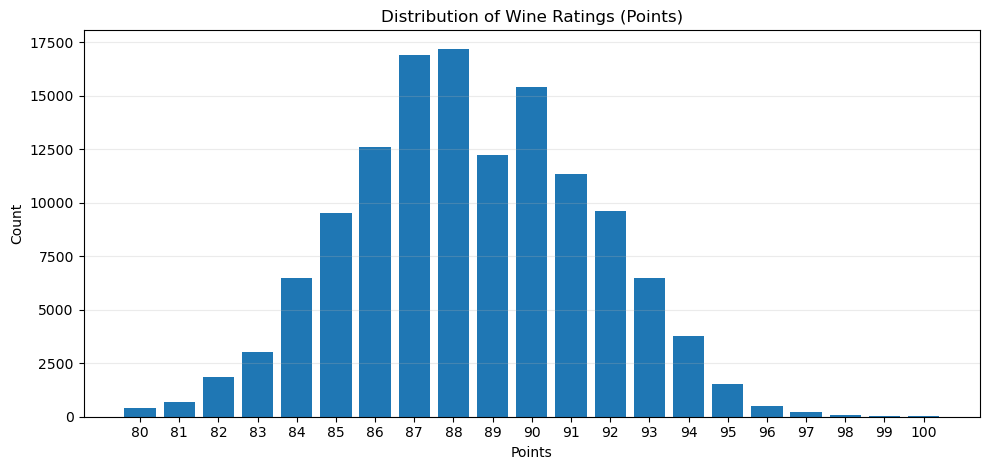

In [27]:
points_counts = wine_df["points"].dropna().astype(int).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 4.8))
ax.bar(points_counts.index, points_counts.values, width=0.8)
ax.set_title("Distribution of Wine Ratings (Points)")
ax.set_xlabel("Points")
ax.set_ylabel("Count")
ax.grid(axis="y", alpha=0.25)
ax.set_xticks(range(int(points_counts.index.min()), int(points_counts.index.max()) + 1))

plt.tight_layout()
plt.show()


## Plot 3: Points Distribution by Province
Violin plot showing the distribution of rating points for the top provinces (by number of reviews).


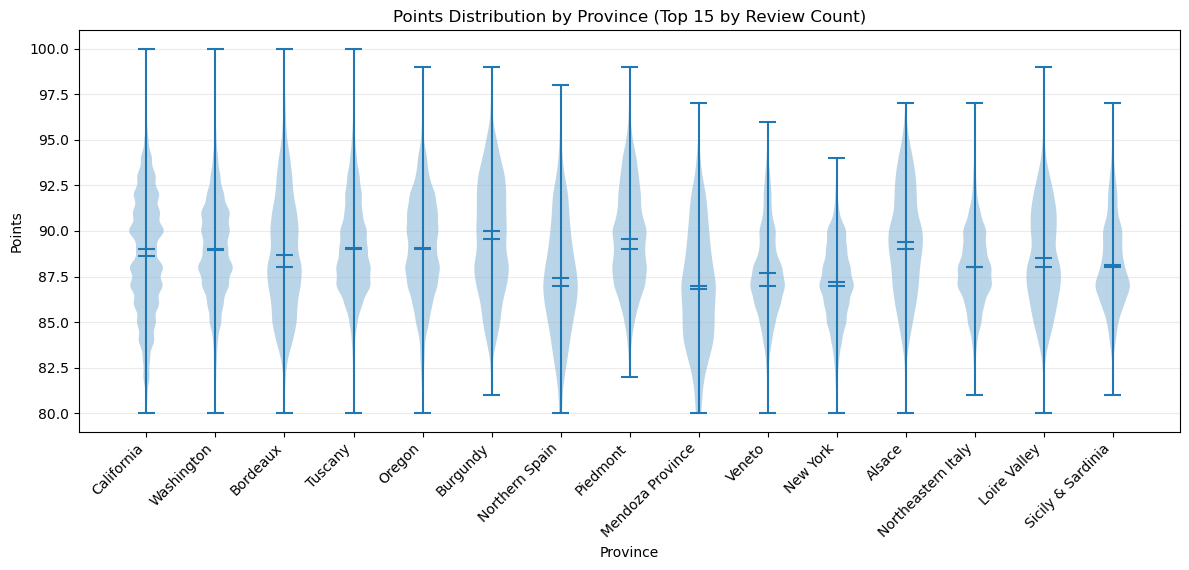

In [28]:
TOP_N_PROVINCES = 15
top_provinces = wine_df["province"].value_counts().head(TOP_N_PROVINCES).index.tolist()

# Extract points data for each top province
province_data = [
    wine_df.loc[wine_df["province"] == p, "points"].dropna().values
    for p in top_provinces
]

fig, ax = plt.subplots(figsize=(12, 5.8))
ax.violinplot(province_data, showmeans=True, showmedians=True)

ax.set_title(f"Points Distribution by Province (Top {TOP_N_PROVINCES} by Review Count)")
ax.set_xlabel("Province")
ax.set_ylabel("Points")
ax.grid(axis="y", alpha=0.25)

positions = np.arange(1, len(top_provinces) + 1)
ax.set_xticks(positions)
ax.set_xticklabels(top_provinces, rotation=45, ha="right")

plt.tight_layout()
plt.show()


## Plot 4: Average Points by Wine Variety
Horizontal bar chart showing average rating points for top wine varieties, with error bars indicating standard deviation.


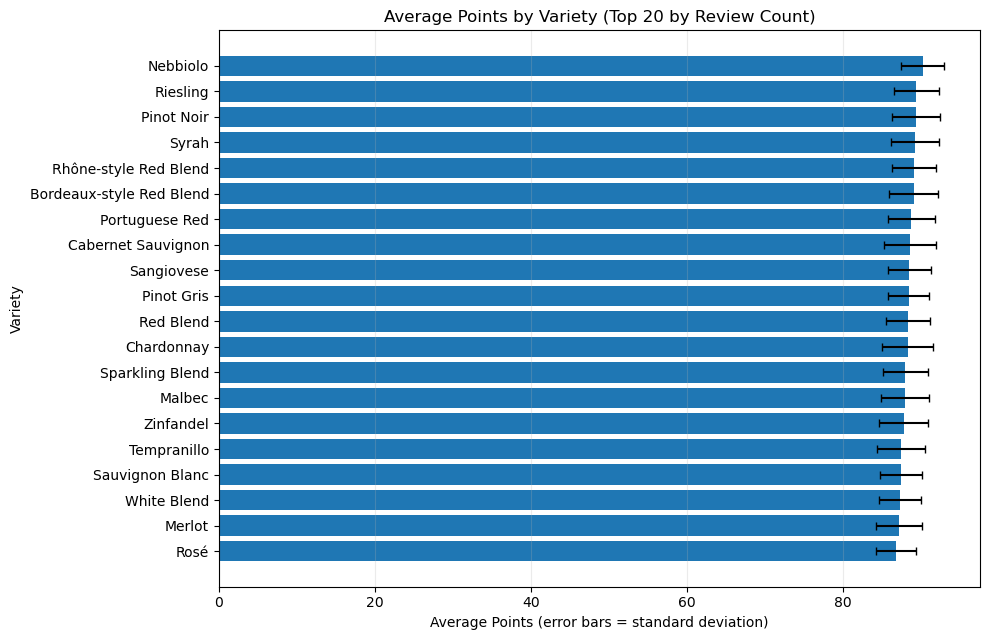

In [29]:
TOP_N_VARIETIES = 20

variety_stats = (
    wine_df.dropna(subset=["variety", "points"])
    .groupby("variety")["points"]
    .agg(["count", "mean", "std"])
    .sort_values("count", ascending=False)
    .head(TOP_N_VARIETIES)
    .sort_values("mean")  # Sort by mean for better visualization
)

fig, ax = plt.subplots(figsize=(10, 6.5))
ax.barh(
    variety_stats.index,
    variety_stats["mean"],
    xerr=variety_stats["std"].fillna(0),
    capsize=3
)

ax.set_title(f"Average Points by Variety (Top {TOP_N_VARIETIES} by Review Count)")
ax.set_xlabel("Average Points (error bars = standard deviation)")
ax.set_ylabel("Variety")
ax.grid(axis="x", alpha=0.25)

plt.tight_layout()
plt.show()


## Plot 5: Province Price Distribution by Country
Box plots showing the distribution of average province prices within the top 10 countries by review count. Each point represents a province's average price.


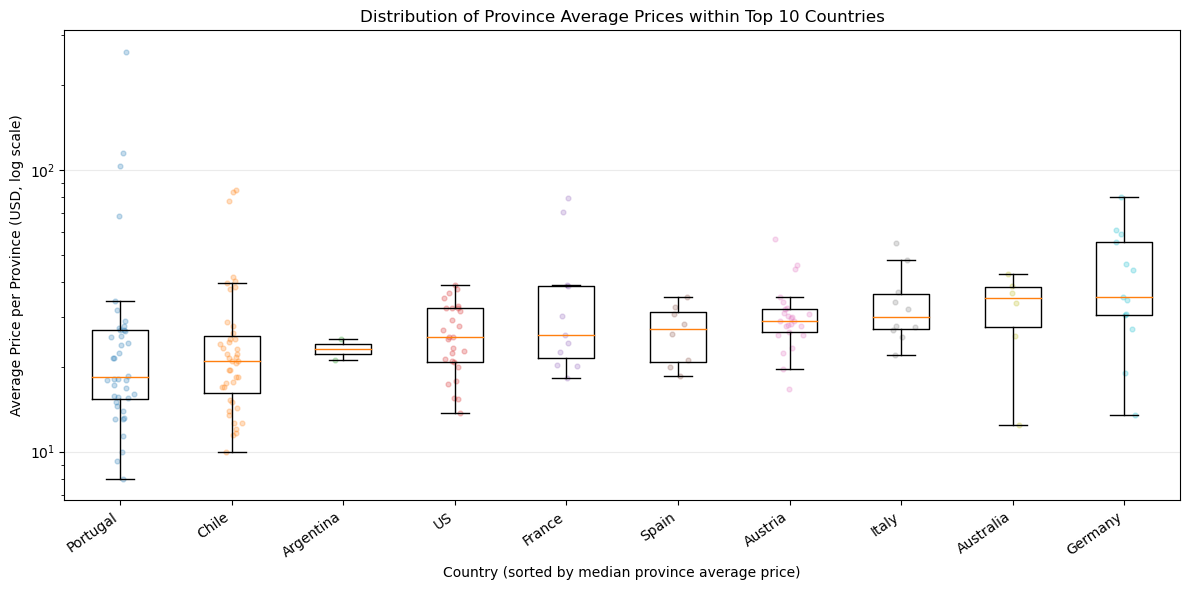

In [30]:
# Filter to rows with valid prices
df_with_price = wine_df.dropna(subset=["price"]).copy()
df_with_price = df_with_price[df_with_price["price"] > 0]

# Select top 10 countries by number of priced reviews
TOP_N_COUNTRIES_PRICE = 10
top_countries_price = (
    df_with_price[df_with_price["country"] != "Unknown"]["country"]
    .value_counts()
    .head(TOP_N_COUNTRIES_PRICE)
    .index
)

# Calculate average price per province within each country
province_avg_prices = (
    df_with_price[df_with_price["country"].isin(top_countries_price)]
    .groupby(["country", "province"])["price"]
    .mean()
    .reset_index(name="avg_price")
)

# Build data arrays: one array per country (province average prices)
price_data = []
country_labels = []
for country in top_countries_price:
    prices = province_avg_prices.loc[
        province_avg_prices["country"] == country, "avg_price"
    ].values
    price_data.append(prices)
    country_labels.append(country)

# Sort countries by median province-average price
medians = [np.median(v) if len(v) > 0 else np.nan for v in price_data]
sort_order = np.argsort(medians)
price_data = [price_data[i] for i in sort_order]
country_labels = [country_labels[i] for i in sort_order]

# Create box plot with jittered scatter overlay
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(price_data, labels=country_labels, showfliers=False)

# Overlay jittered points (each dot = one province's average price)
rng = np.random.default_rng(42)
for i, prices in enumerate(price_data, start=1):
    x_jitter = i + rng.normal(0, 0.06, size=len(prices))
    ax.scatter(x_jitter, prices, alpha=0.25, s=12)

ax.set_yscale("log")
ax.set_title("Distribution of Province Average Prices within Top 10 Countries")
ax.set_xlabel("Country (sorted by median province average price)")
ax.set_ylabel("Average Price per Province (USD, log scale)")
ax.grid(axis="y", alpha=0.25)

plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()
